## Regression Model

In [69]:
df = pd.read_csv('risk_regression.csv')
df.head()

,Unnamed: 0,age,gender,height,weight,state,bmi_app_state,income_app_state,current_ins,current_ins_value,...,weight_loss,weight_loss_amount,weight_loss_reason,cancer_type,citizen,legal_resident,skydive_count,surgery_type,travel_countries,risk
0,0,48.534878,2.237432,68.0,195.0,2.188135,29.646410,36400,2.275373,0.0,...,False,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.0
1,1,42.716825,2.237432,67.0,200.0,2.293705,31.321007,9528,2.275373,0.0,...,False,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.0
2,2,54.399474,2.237432,66.0,193.0,2.335329,31.147612,9396,2.275373,0.0,...,False,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.0
3,3,50.336420,2.282821,63.0,140.0,2.344419,24.797178,82000,2.275373,0.0,...,True,20.0,2.999326,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.0
4,4,42.725039,2.282821,61.0,132.0,2.436622,24.938457,72000,2.275373,0.0,...,False,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.0


In [70]:
df.shape

(169901, 67)

In [71]:
df.risk.unique()

array([3.  , 0.8 , 1.23, 1.45, 0.9 , 2.25, 2.5 , 0.7 , 2.  , 2.65])

In [72]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

features = train.drop('risk', axis=1)
target = train['risk']
test_features = test.drop('risk', axis=1)
test_target = test['risk']

In [73]:
from sklearn.utils import compute_sample_weight
weights = compute_sample_weight(class_weight='balanced', y=target)

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

features = train.drop('risk', axis=1)
target = train['risk']
test_features = test.drop('risk', axis=1)
test_target = test['risk']

# Define a list of regression models to try
models = [
    Ridge(),
#     DecisionTreeRegressor(),
    RandomForestRegressor(),
#     SVR()
]

# Define a pipeline that includes a preprocessing step and a regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', None)
])

# Define a grid of hyperparameters to search over
param_grid = [
    {'regressor': [Ridge()], 'regressor__alpha': [0.01, 1.0]},
#     {'regressor': [DecisionTreeRegressor()], 'regressor__max_depth': [2, 6]},
    {'regressor': [RandomForestRegressor()], 'regressor__n_estimators': [50, 150], 'regressor__max_depth': [2, 6]},
#     {'regressor': [SVR()], 'regressor__C': [0.1, 10.0], 'regressor__kernel': ['linear', 'rbf']}
]

# Perform a grid search over the hyperparameter space
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the pipeline using the training data
grid_search.fit(features, target)

# Evaluate the performance of the pipeline using the test data
y_pred = grid_search.predict(test_features)
mse = mean_squared_error(test_target, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test_target, y_pred)

In [75]:
print(rmse, r2)

0.688665010160609 0.391140712250726


### CatBoost Regressor

In [77]:
from catboost import CatBoostRegressor

# Define the CatBoostRegressor model and fit to the training data
cat_reg = CatBoostRegressor(
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    iterations=1000, # the number of boosting iterations to perform
    random_seed=42, # for reproducibility
    loss_function='RMSE', # the loss function to optimize
    verbose=False # whether to print training information
)

# cat_reg.fit(features, target, sample_weight = weights)
cat_reg.fit(features, target)
cat_reg_preds = cat_reg.predict(test_features)

# Evaluate the model performance
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_target, cat_reg_preds)*0.5
print("RMSE:", rmse)

RMSE: 0.1416948849701174


In [66]:
test_features['risk'] = test_target
test_features['predicted_risk'] = cat_reg_preds
test_features.head(100)

,Unnamed: 0,age,gender,height,weight,state,bmi_app_state,income_app_state,current_ins,current_ins_value,...,weight_loss_amount,weight_loss_reason,cancer_type,citizen,legal_resident,skydive_count,surgery_type,travel_countries,risk,predicted_risk
67257,68745,45.772329,2.237432,75.0,190.0,2.275430,23.745778,60000,2.275373,0.0,...,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.00,1.062484
55709,56933,52.488415,2.237432,76.0,251.0,2.252721,30.549342,47160,2.175125,25000.0,...,20.0,2.246597,2.247829,2.268826,2.256483,0.0,2.532724,2.266178,3.00,2.997919
121978,124539,52.096895,2.237432,69.0,190.0,2.188135,28.055030,93600,2.275373,0.0,...,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,1.45,1.148511
809,827,48.291204,2.282821,64.0,163.0,2.365559,27.975830,60000,2.175125,100000.0,...,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,0.80,1.188425
9732,9939,47.092001,2.237432,66.0,205.0,2.387607,33.084252,46800,2.275373,0.0,...,20.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.00,3.224683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159835,163183,26.601504,2.282821,67.0,132.0,2.275430,20.671865,19200,2.275373,0.0,...,0.0,2.246597,2.247829,2.076737,2.256483,0.0,2.231982,2.266178,0.90,1.140781
86271,88111,51.557527,2.237432,74.0,200.0,2.237391,25.675676,48000,2.275373,0.0,...,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.00,2.480245
164943,168407,38.952203,2.282821,65.0,160.0,2.109037,26.622485,61200,2.175125,252500.0,...,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.00,0.988727
35328,36031,45.640910,2.237432,72.0,165.0,2.188135,22.375579,21840,2.275373,0.0,...,0.0,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,2.50,2.534983


In [67]:
# convert risk and predicted risk back to risk class
# Define the relative_risk_map dictionary
risk_map = {
    0.70:'super_elite_nt',
    0.80:'elite_nt',
    0.90:'preferred_nt',
    1.23:'select_nt',
    1.45:'essential_nt',
    2.00:'essential_plus_nt',
    2.25:'select_tb',
    2.50:'essential_tb',
    2.65:'essential_plus_tb',
    3.00:'declined',

}


# Map the 'approved risk class' column to the dictionary values and create a new column 'relative_risk'
test_features['risk_class'] = test_features['risk'].map(risk_map)
test_features.head()

,Unnamed: 0,age,gender,height,weight,state,bmi_app_state,income_app_state,current_ins,current_ins_value,...,weight_loss_reason,cancer_type,citizen,legal_resident,skydive_count,surgery_type,travel_countries,risk,predicted_risk,risk_class
67257,68745,45.772329,2.237432,75.0,190.0,2.275430,23.745778,60000,2.275373,0.0,...,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.00,1.062484,declined
55709,56933,52.488415,2.237432,76.0,251.0,2.252721,30.549342,47160,2.175125,25000.0,...,2.246597,2.247829,2.268826,2.256483,0.0,2.532724,2.266178,3.00,2.997919,declined
121978,124539,52.096895,2.237432,69.0,190.0,2.188135,28.055030,93600,2.275373,0.0,...,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,1.45,1.148511,essential_nt
809,827,48.291204,2.282821,64.0,163.0,2.365559,27.975830,60000,2.175125,100000.0,...,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,0.80,1.188425,elite_nt
9732,9939,47.092001,2.237432,66.0,205.0,2.387607,33.084252,46800,2.275373,0.0,...,2.246597,2.247829,2.268826,2.256483,0.0,2.231982,2.266178,3.00,3.224683,declined


In [68]:
test_features['predicted_risk'].max()

4.513595029058007

In [69]:
test_features['predicted_risk'].min()

0.6227425654371888

In [77]:
test_features['predicted_risk_class'] = pd.cut(test_features['predicted_risk'], 
                                                bins = [0, 0.7, 0.8, 0.9, 1.23, 1.45, 2, 2.25, 2.5, 2.65, 5],
                                               labels = ['super_elite', 'elite_nt', 'preferred_nt', 'select_nt', 
                                                'essential_nt','essential_plus_nt', 'select_tb','essential_tb',
                                                'essential_plus_tb','declined'])
test_features.head()

,Unnamed: 0,age,gender,height,weight,state,bmi_app_state,income_app_state,current_ins,current_ins_value,...,citizen,legal_resident,skydive_count,surgery_type,travel_countries,risk,predicted_risk,risk_class,predicted_risk_class,agree
67257,68745,45.772329,2.237432,75.0,190.0,2.275430,23.745778,60000,2.275373,0.0,...,2.268826,2.256483,0.0,2.231982,2.266178,3.00,1.062484,declined,select_nt,0
55709,56933,52.488415,2.237432,76.0,251.0,2.252721,30.549342,47160,2.175125,25000.0,...,2.268826,2.256483,0.0,2.532724,2.266178,3.00,2.997919,declined,declined,0
121978,124539,52.096895,2.237432,69.0,190.0,2.188135,28.055030,93600,2.275373,0.0,...,2.268826,2.256483,0.0,2.231982,2.266178,1.45,1.148511,essential_nt,select_nt,0
809,827,48.291204,2.282821,64.0,163.0,2.365559,27.975830,60000,2.175125,100000.0,...,2.268826,2.256483,0.0,2.231982,2.266178,0.80,1.188425,elite_nt,select_nt,0
9732,9939,47.092001,2.237432,66.0,205.0,2.387607,33.084252,46800,2.275373,0.0,...,2.268826,2.256483,0.0,2.231982,2.266178,3.00,3.224683,declined,declined,1


In [78]:
test_features['agree'] = test_features.apply(lambda x: 1 if x.risk_class == x.predicted_risk_class else 0, axis=1)
test_features.head()

,Unnamed: 0,age,gender,height,weight,state,bmi_app_state,income_app_state,current_ins,current_ins_value,...,citizen,legal_resident,skydive_count,surgery_type,travel_countries,risk,predicted_risk,risk_class,predicted_risk_class,agree
67257,68745,45.772329,2.237432,75.0,190.0,2.275430,23.745778,60000,2.275373,0.0,...,2.268826,2.256483,0.0,2.231982,2.266178,3.00,1.062484,declined,select_nt,0
55709,56933,52.488415,2.237432,76.0,251.0,2.252721,30.549342,47160,2.175125,25000.0,...,2.268826,2.256483,0.0,2.532724,2.266178,3.00,2.997919,declined,declined,1
121978,124539,52.096895,2.237432,69.0,190.0,2.188135,28.055030,93600,2.275373,0.0,...,2.268826,2.256483,0.0,2.231982,2.266178,1.45,1.148511,essential_nt,select_nt,0
809,827,48.291204,2.282821,64.0,163.0,2.365559,27.975830,60000,2.175125,100000.0,...,2.268826,2.256483,0.0,2.231982,2.266178,0.80,1.188425,elite_nt,select_nt,0
9732,9939,47.092001,2.237432,66.0,205.0,2.387607,33.084252,46800,2.275373,0.0,...,2.268826,2.256483,0.0,2.231982,2.266178,3.00,3.224683,declined,declined,1


In [79]:
test_features.groupby(['risk_class','agree'])['age'].count()

risk_class         agree
declined           0         8261
                   1        10506
elite_nt           0         1742
                   1           96
essential_nt       0         3430
                   1         1009
essential_plus_nt  0          100
                   1          198
essential_plus_tb  0           77
                   1           75
essential_tb       0          274
                   1          326
preferred_nt       0         1912
                   1          173
select_nt          0         3139
                   1         1425
select_tb          0          962
                   1           35
super_elite_nt     0          241
Name: age, dtype: int64

In [81]:
test_features.groupby(['agree'])['age'].count()

agree
0    20138
1    13843
Name: age, dtype: int64

In [80]:
test_features.groupby(['risk_class'])['agree'].mean()

risk_class
declined             0.559812
elite_nt             0.052231
essential_nt         0.227303
essential_plus_nt    0.664430
essential_plus_tb    0.493421
essential_tb         0.543333
preferred_nt         0.082974
select_nt            0.312226
select_tb            0.035105
super_elite_nt       0.000000
Name: agree, dtype: float64

In [439]:
test_features.shape

(32276, 71)

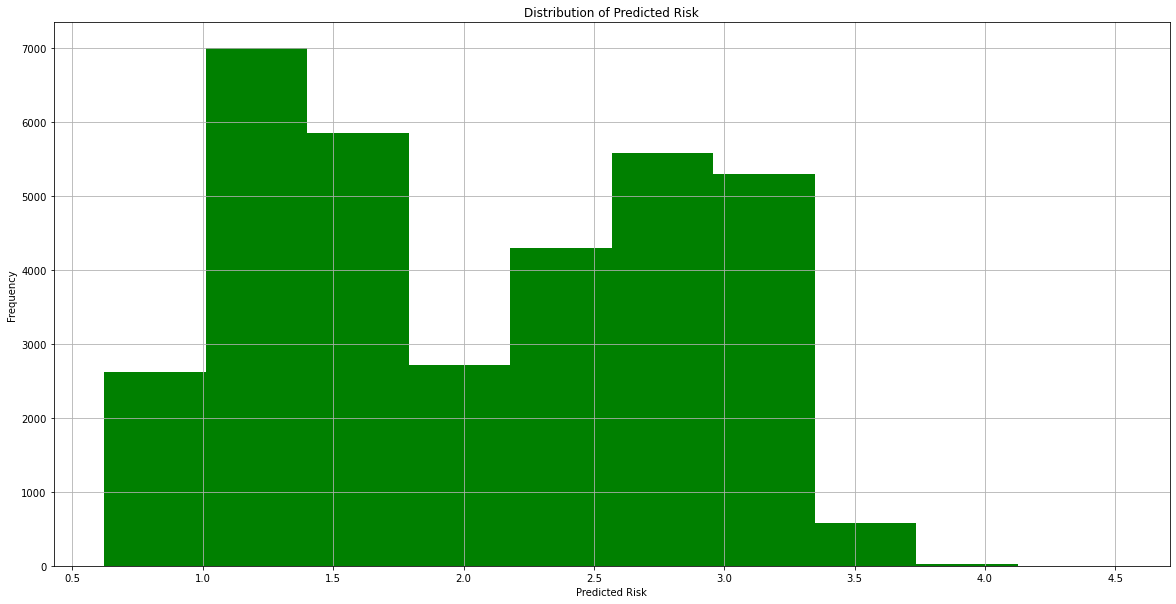

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# plot a histogram of the 'age' column
test_features.hist(column='predicted_risk', bins=10, color='green')

# customize the plot
plt.title('Distribution of Predicted Risk')
plt.xlabel('Predicted Risk')
plt.ylabel('Frequency')
plt.show()


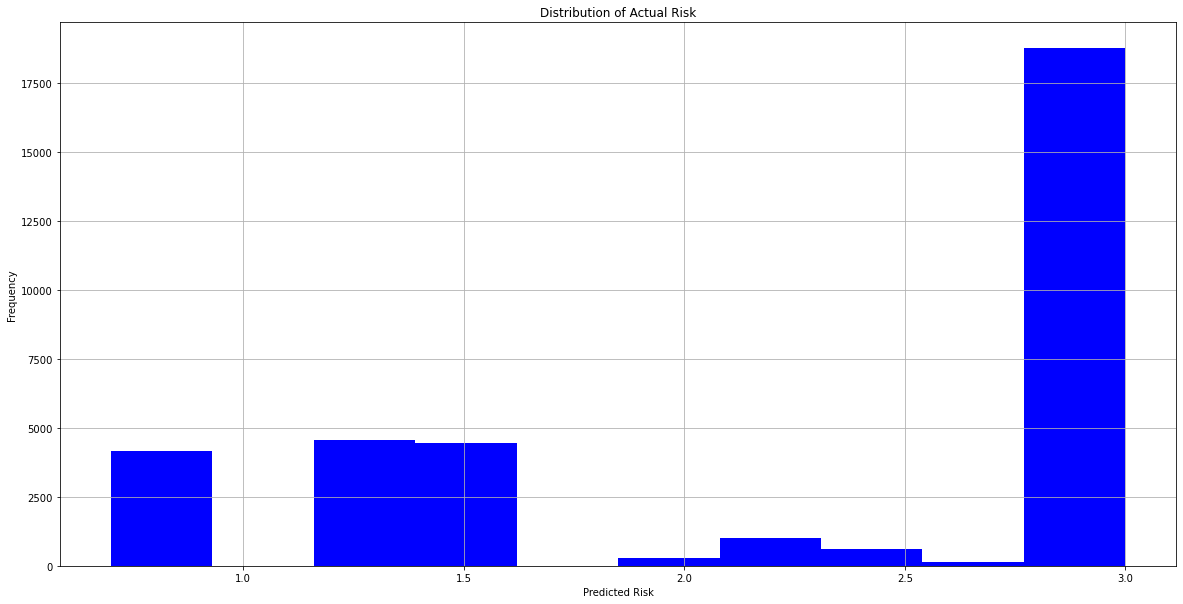

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# plot a histogram of the 'age' column
test_features.hist(column='risk', bins=10, color='blue')

# customize the plot
plt.title('Distribution of Actual Risk')
plt.xlabel('Predicted Risk')
plt.ylabel('Frequency')
plt.show()

In [446]:
replace_dict = {'super_elite_nt': 'elite_nt', 'essential_plus_nt': 'essential_nt'}

test_features['risk_simple'] = test_features['risk_class'].replace(replace_dict)
test_features['predicted_risk_simple'] = test_features['predicted_risk_class'].replace(replace_dict)

In [448]:
test_features['simple_agree'] = test_features.apply(lambda x: 1 if x.risk_simple == x.predicted_risk_simple else 0, axis=1)
test_features.groupby(['risk_simple', 'simple_agree'])['age'].count()

risk_simple   simple_agree
declined      0               12496
              1                6318
elite_nt      0                2004
              1                  20
essential_nt  0                1330
              1                3299
preferred_nt  0                1668
              1                 477
select_nt     0                3369
              1                1295
Name: age, dtype: int64